In [28]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## data preparation

In [29]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt


In [31]:
# Load in the training set
training_set = pd.read_csv("log_mini.csv")
training_set.hist_user_behavior_reason_start = training_set.hist_user_behavior_reason_start.astype('category')
training_set.hist_user_behavior_reason_end = training_set.hist_user_behavior_reason_end.astype('category')
training_set.context_type = training_set.context_type.astype('category')
training_set.date = training_set.date.apply(pd.to_datetime)

# Using skip_2 as the ground truth
training_set['skipped'] = (training_set.skip_2 | training_set.skip_1).astype('int32')
training_set = training_set.drop(columns=['skip_1','skip_2','skip_3','not_skipped'])
training_set

,session_id,session_position,session_length,track_id_clean,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hist_user_behavior_is_shuffle,hour_of_day,date,premium,context_type,hist_user_behavior_reason_start,hist_user_behavior_reason_end,skipped
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,1,20,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,0,0,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone,0
1,0_00006f66-33e5-4de7-a324-2d18e439fc1e,2,20,t_9099cd7b-c238-47b7-9381-f23f2c1d1043,0,1,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone,0
2,0_00006f66-33e5-4de7-a324-2d18e439fc1e,3,20,t_fc5df5ba-5396-49a7-8b29-35d0d28249e0,0,1,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone,0
3,0_00006f66-33e5-4de7-a324-2d18e439fc1e,4,20,t_23cff8d6-d874-4b20-83dc-94e450e8aa20,0,1,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone,0
4,0_00006f66-33e5-4de7-a324-2d18e439fc1e,5,20,t_64f3743c-f624-46bb-a579-0f3f9a07a123,0,1,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167875,0_0eaeef5d-25e9-4429-bd55-af15d3604c9f,16,20,t_360910e8-2a84-42b0-baf1-59abcf96a1f2,0,1,0,0,0,0,False,13,2018-07-15,True,user_collection,trackdone,trackdone,0
167876,0_0eaeef5d-25e9-4429-bd55-af15d3604c9f,17,20,t_aa2fff77-9b0a-4fa3-a685-ecef50310e8a,0,1,0,0,0,0,False,13,2018-07-15,True,user_collection,trackdone,trackdone,0
167877,0_0eaeef5d-25e9-4429-bd55-af15d3604c9f,18,20,t_f673e1b7-4ebe-4fc1-ac24-a9f25de70381,0,1,0,0,0,0,False,13,2018-07-15,True,user_collection,trackdone,trackdone,0
167878,0_0eaeef5d-25e9-4429-bd55-af15d3604c9f,19,20,t_e172e8e7-7161-42a9-acb0-d606346c8f87,0,1,0,0,0,0,False,13,2018-07-15,True,user_collection,trackdone,trackdone,0


## psm

In [32]:
# each session can have different context_type and context_switch means if the user change the playlist in the session
training_set[training_set["session_id"]=="0_000641b5-a2ce-4803-bdeb-499c548ba50d"][["session_id","context_type"]].groupby(["session_id","context_type"]).size().head(100)

session_id                              context_type         
0_000641b5-a2ce-4803-bdeb-499c548ba50d  catalog                  10
                                        charts                    0
                                        editorial_playlist        0
                                        personalized_playlist     0
                                        radio                    10
                                        user_collection           0
dtype: int64

In [33]:
session=training_set.groupby("session_id").agg(
     track_num=pd.NamedAgg(column="track_id_clean",aggfunc="count"),
     if_switch_playlist=pd.NamedAgg(column="context_switch",aggfunc=max),
     no_pause_number=pd.NamedAgg(column="no_pause_before_play",aggfunc=sum),
     short_pause_number=pd.NamedAgg(column="short_pause_before_play",aggfunc=sum),
     long_pause_number=pd.NamedAgg(column="long_pause_before_play",aggfunc=sum),
     hist_user_behavior_n_seekfwd=pd.NamedAgg(column="hist_user_behavior_n_seekfwd",aggfunc=sum),
     hist_user_behavior_n_seekback=pd.NamedAgg(column="hist_user_behavior_n_seekback",aggfunc=sum),
     hour_of_day=pd.NamedAgg(column="hour_of_day",aggfunc=max),
     premium=pd.NamedAgg(column="premium",aggfunc=max),
     skipped=pd.NamedAgg(column="skipped",aggfunc=sum)
).reset_index()
session.head()

,session_id,track_num,if_switch_playlist,no_pause_number,short_pause_number,long_pause_number,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hour_of_day,premium,skipped
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,20,0,18,1,1,0,0,16,True,13
1,0_0000a72b-09ac-412f-b452-9b9e79bded8f,20,0,16,3,3,0,1,15,True,10
2,0_00010fc5-b79e-4cdf-bc4c-f140d0f99a3a,20,0,14,3,5,0,0,19,True,12
3,0_00016a3d-9076-4f67-918f-f29e3ce160dc,20,0,7,12,12,0,0,17,True,16
4,0_00018b58-deb8-4f98-ac5e-d7e01b346130,11,1,9,1,1,0,1,13,True,1


In [34]:
session

,session_id,track_num,if_switch_playlist,no_pause_number,short_pause_number,long_pause_number,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hour_of_day,premium,skipped
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,20,0,18,1,1,0,0,16,True,13
1,0_0000a72b-09ac-412f-b452-9b9e79bded8f,20,0,16,3,3,0,1,15,True,10
2,0_00010fc5-b79e-4cdf-bc4c-f140d0f99a3a,20,0,14,3,5,0,0,19,True,12
3,0_00016a3d-9076-4f67-918f-f29e3ce160dc,20,0,7,12,12,0,0,17,True,16
4,0_00018b58-deb8-4f98-ac5e-d7e01b346130,11,1,9,1,1,0,1,13,True,1
...,...,...,...,...,...,...,...,...,...,...,...
9995,0_0eac164c-f209-4590-8608-a56e67658952,20,0,18,1,1,0,0,15,True,15
9996,0_0eacbee7-9868-48a0-9ab0-f86069329f50,20,0,16,3,3,0,2,19,True,17
9997,0_0ead11fc-f32c-4eb4-8fc1-15b51432a404,20,0,11,8,8,0,0,22,True,12
9998,0_0eae096d-ae4c-4556-8227-0f6294958330,12,0,9,1,2,0,0,20,True,8


In [35]:
!pip install psmpy
from psmpy import PsmPy
from psmpy.functions import cohenD
from psmpy.plotting import *


In [36]:
psm = PsmPy(session, treatment='premium', indx='session_id', exclude = ["skipped"])

In [37]:
psm.logistic_ps(balance = True)

In [ ]:
psm.predicted_data.head()

In [38]:
# use 1:1 KNN matching method, and no restriction to the matching neighbours
psm.knn_matched(matcher='propensity_logit', replacement=False)


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but NearestNeighbors was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


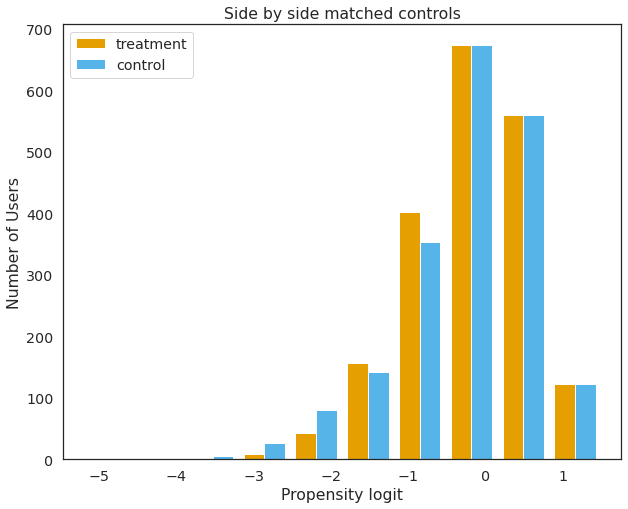

In [39]:
import seaborn as sns
sns.set(rc={'figure.figsize':(10,8)}, font_scale = 1.3)
psm.plot_match(Title='Side by side matched controls', Ylabel='Number of Users', Xlabel= 'Propensity logit', names = ['treatment', 'control'], save=True)

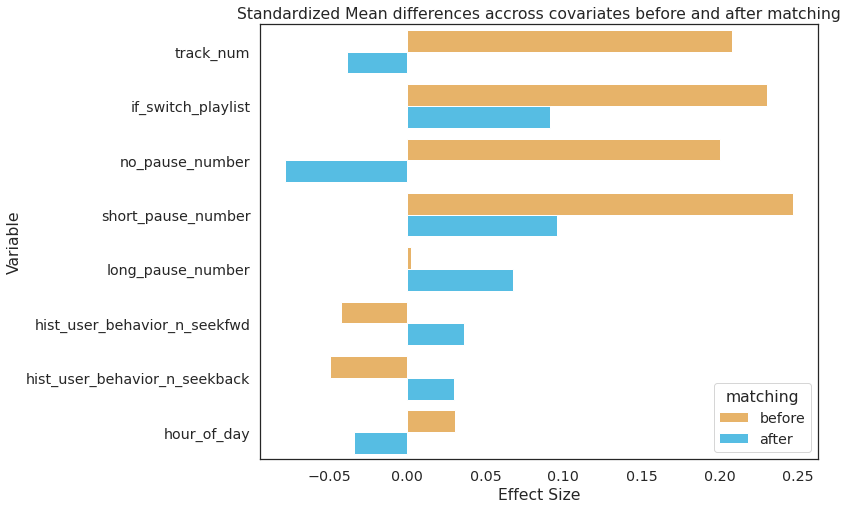

In [40]:
psm.effect_size_plot(save=False)

In [41]:
psm.matched_ids

,session_id,matched_ID
0,0_00030fe3-298d-4930-8534-fc5a9b82971b,0_09617d9c-2bac-4367-9702-689a8e15009b
1,0_000822a0-d9a2-4346-9fef-2b5d68e12bc2,0_01365638-6cba-4a6f-9188-128b93ff5593
2,0_0009bdeb-b5b7-4073-9b01-b72a32c77cda,0_037a0c8c-e0b1-4102-a8a6-c37d40d608a9
3,0_000a6cae-aef1-4a3e-b1bd-d1971edfcb41,0_0aea200a-57fb-4a62-8c55-39d2e352c54b
4,0_000cec57-79f9-4acf-87a1-9bb9063d012d,0_0a5da48b-0266-4e4a-ae10-41173da4e5e4
...,...,...
1965,0_0e9fc88b-f1d3-4d43-b17c-931c53e9b652,0_00fd371a-ee00-40e7-bcee-00fb67ecac89
1966,0_0ea14f73-464c-4ef5-86fe-8d6a842a031b,0_063822d1-e253-4178-a833-eea43aa4aadf
1967,0_0ea2015c-84ff-465e-871d-5be6cce7dc49,0_0bdd1377-1d09-4f69-993e-81110440b52f
1968,0_0ea75a3d-9151-444e-a7d2-df2b97d89e05,0_09c33f11-8fc4-413e-a2b4-63c8f0f5ddeb


In [42]:
psm.effect_size

,Variable,matching,Effect Size
0,track_num,before,0.208081
1,track_num,after,-0.038817
2,if_switch_playlist,before,0.230162
3,if_switch_playlist,after,0.091153
4,no_pause_number,before,0.200273
5,no_pause_number,after,-0.078122
6,short_pause_number,before,0.246944
7,short_pause_number,after,0.095726
8,long_pause_number,before,0.002231
9,long_pause_number,after,0.067736


In [43]:
untreated_matched_data = session[session['session_id'].isin(psm.matched_ids['session_id']) == True]

In [44]:
treated_matched_data = session[session['session_id'].isin(psm.matched_ids['matched_ID']) == True]

In [45]:
all_matched = pd.concat([treated_matched_data, untreated_matched_data])

In [46]:
all_matched

,session_id,track_num,if_switch_playlist,no_pause_number,short_pause_number,long_pause_number,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hour_of_day,premium,skipped
2,0_00010fc5-b79e-4cdf-bc4c-f140d0f99a3a,20,0,14,3,5,0,0,19,True,12
5,0_00027db1-ffe5-4b00-8eeb-8d8188451298,15,1,9,3,5,0,0,9,True,1
9,0_0003ac37-c70a-47a6-b9dc-b8b163826082,20,0,13,5,6,0,2,12,True,4
28,0_0008bd24-bbb0-4747-b777-7c97ce5ab3a9,20,1,12,7,7,0,0,10,True,10
30,0_00094b63-0ef1-4cec-94e5-30879a3cce28,20,0,13,3,6,0,4,9,True,6
...,...,...,...,...,...,...,...,...,...,...,...
9967,0_0e9fc88b-f1d3-4d43-b17c-931c53e9b652,10,0,9,0,0,5,11,12,False,4
9971,0_0ea14f73-464c-4ef5-86fe-8d6a842a031b,12,0,6,5,5,0,0,11,False,5
9972,0_0ea2015c-84ff-465e-871d-5be6cce7dc49,10,0,8,0,1,0,0,18,False,2
9985,0_0ea75a3d-9151-444e-a7d2-df2b97d89e05,20,0,11,7,8,0,0,16,False,14


In [47]:
overview = all_matched[['skipped','premium']].groupby(by = ['premium']).aggregate([np.mean, np.var, np.std, 'count'])
print(overview)

          skipped                           
             mean        var       std count
premium                                     
False    8.622335  25.730329  5.072507  1970
True     8.035025  23.155197  4.811985  1970


In [48]:
treated_outcome = overview['skipped']['mean'][1]
treated_counterfactual_outcome = overview['skipped']['mean'][0]

In [49]:
ate = (treated_outcome - treated_counterfactual_outcome)
print('The Average Treatment Effect (ATE): {:.4f}'.format(ate))

The Average Treatment Effect (ATE): -0.5873


In [50]:
all_matched

,session_id,track_num,if_switch_playlist,no_pause_number,short_pause_number,long_pause_number,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hour_of_day,premium,skipped
2,0_00010fc5-b79e-4cdf-bc4c-f140d0f99a3a,20,0,14,3,5,0,0,19,True,12
5,0_00027db1-ffe5-4b00-8eeb-8d8188451298,15,1,9,3,5,0,0,9,True,1
9,0_0003ac37-c70a-47a6-b9dc-b8b163826082,20,0,13,5,6,0,2,12,True,4
28,0_0008bd24-bbb0-4747-b777-7c97ce5ab3a9,20,1,12,7,7,0,0,10,True,10
30,0_00094b63-0ef1-4cec-94e5-30879a3cce28,20,0,13,3,6,0,4,9,True,6
...,...,...,...,...,...,...,...,...,...,...,...
9967,0_0e9fc88b-f1d3-4d43-b17c-931c53e9b652,10,0,9,0,0,5,11,12,False,4
9971,0_0ea14f73-464c-4ef5-86fe-8d6a842a031b,12,0,6,5,5,0,0,11,False,5
9972,0_0ea2015c-84ff-465e-871d-5be6cce7dc49,10,0,8,0,1,0,0,18,False,2
9985,0_0ea75a3d-9151-444e-a7d2-df2b97d89e05,20,0,11,7,8,0,0,16,False,14


In [51]:
from statsmodels.formula.api import ols

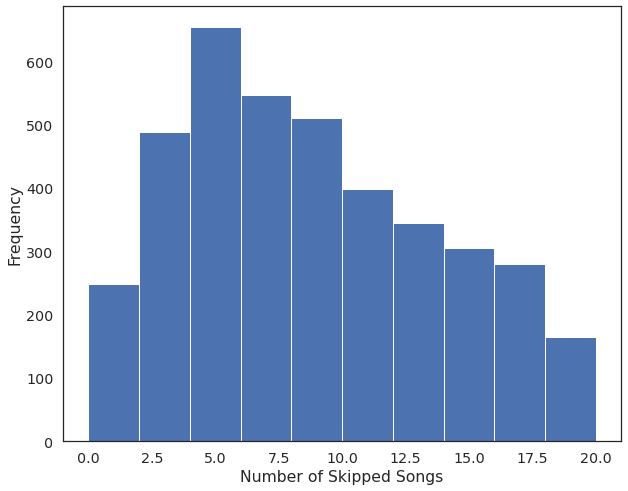

In [52]:
x = all_matched['skipped']
bins = np.linspace(0, 20, 11)
plt.hist(x, bins)
plt.xlabel('Number of Skipped Songs')
plt.ylabel('Frequency')
plt.show()

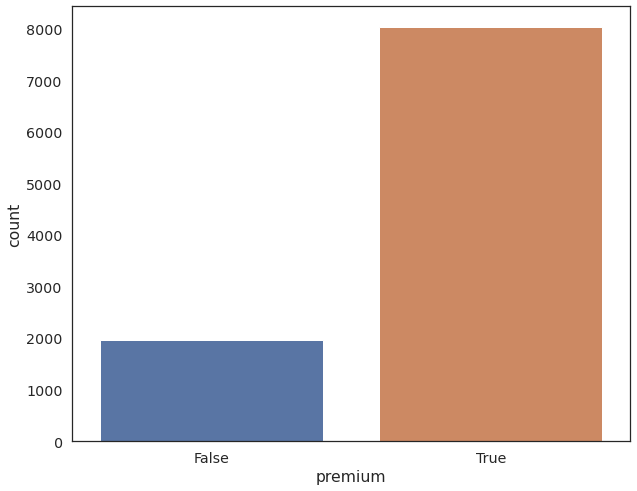

In [53]:
ax = sns.countplot(x="premium", data=session)


In [54]:
#effect with matching
fit = ols('skipped ~ C(premium)', data=all_matched).fit() 
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                skipped   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     13.90
Date:                Sat, 07 May 2022   Prob (F-statistic):           0.000195
Time:                        23:14:11   Log-Likelihood:                -11886.
No. Observations:                3940   AIC:                         2.378e+04
Df Residuals:                    3938   BIC:                         2.379e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              8.6223      0.111     77.407      0.000       8.404       8.841
C(premium)[T.True]    -0.5873      0.158     -3.728      0.000      -0.896      -0.278
==============================================================================
Omnibus:                      623.019   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              227.507
Skew:                           0.379   Prob(JB):                     3.96e-50
Kurtosis:                       2.100   Cond. No.                         2.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [55]:
# effect without matching
fit = ols('skipped ~ C(premium)', data=session).fit() 
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                skipped   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.3437
Date:                Sat, 07 May 2022   Prob (F-statistic):              0.558
Time:                        23:14:11   Log-Likelihood:                -30431.
No. Observations:               10000   AIC:                         6.087e+04
Df Residuals:                    9998   BIC:                         6.088e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              8.6223      0.114     75.417      0.000       8.398       8.846
C(premium)[T.True]     0.0748      0.128      0.586      0.558      -0.175       0.325
==============================================================================
Omnibus:                     2832.459   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              568.523
Skew:                           0.274   Prob(JB):                    3.52e-124
Kurtosis:                       1.969   Cond. No.                         4.30
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but NearestNeighbors was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


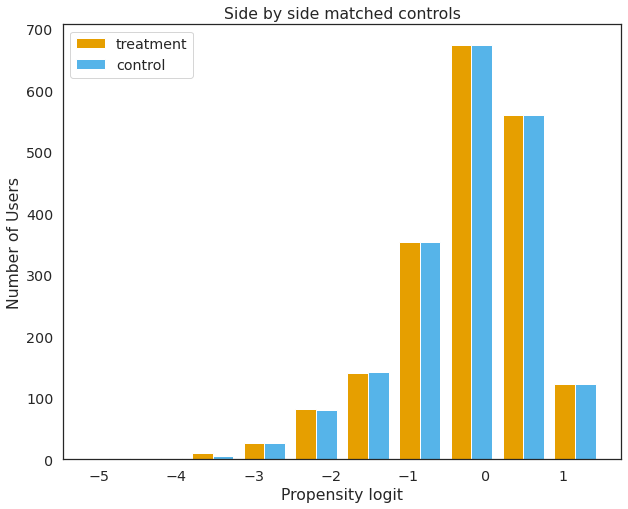

In [57]:
# sensitivity analysis
# change the matching method to with replacement
psm.knn_matched(matcher='propensity_logit', replacement=True)
sns.set(rc={'figure.figsize':(10,8)}, font_scale = 1.3)
psm.plot_match(Title='Side by side matched controls', Ylabel='Number of Users', Xlabel= 'Propensity logit', names = ['treatment', 'control'], save=True)



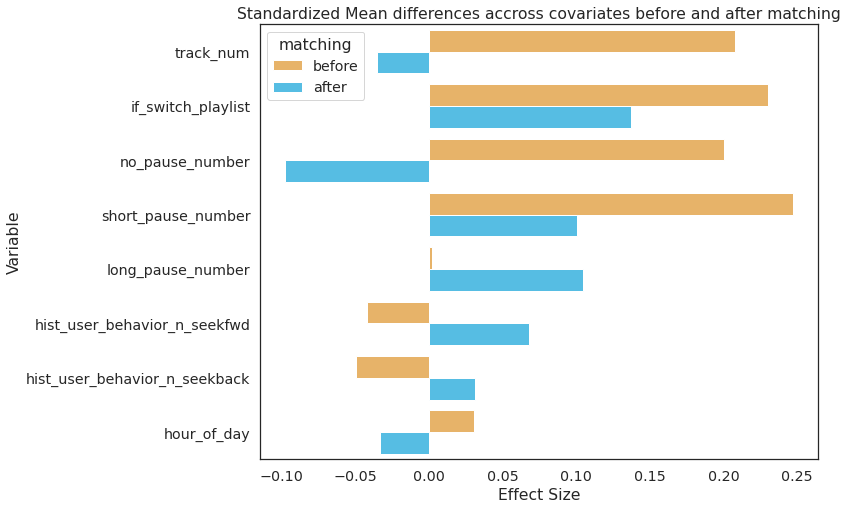

In [58]:
psm.effect_size_plot(save=False)

In [59]:
untreated_matched_data = session[session['session_id'].isin(psm.matched_ids['session_id']) == True]

In [60]:
treated_matched_data = session[session['session_id'].isin(psm.matched_ids['matched_ID']) == True]

In [61]:
all_matched = pd.concat([treated_matched_data, untreated_matched_data])

In [62]:
fit = ols('skipped ~ C(premium)', data=all_matched).fit() 
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                skipped   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     8.396
Date:                Sat, 07 May 2022   Prob (F-statistic):            0.00378
Time:                        23:34:46   Log-Likelihood:                -10162.
No. Observations:                3361   AIC:                         2.033e+04
Df Residuals:                    3359   BIC:                         2.034e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              8.6223      0.112     76.881      0.000       8.402       8.842
C(premium)[T.True]    -0.5052      0.174     -2.898      0.004      -0.847      -0.163
==============================================================================
Omnibus:                      595.010   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              193.918
Skew:                           0.361   Prob(JB):                     7.78e-43
Kurtosis:                       2.070   Cond. No.                         2.46
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but NearestNeighbors was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


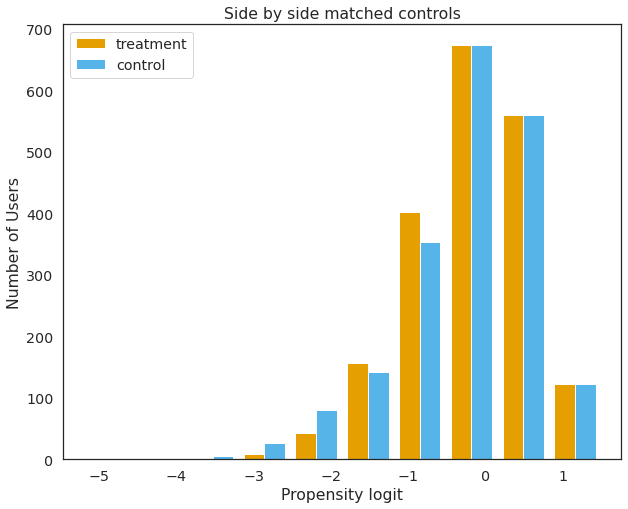

In [63]:
# change to match based on propensity score
psm.knn_matched(matcher='propensity_score', replacement=False)
sns.set(rc={'figure.figsize':(10,8)}, font_scale = 1.3)
psm.plot_match(Title='Side by side matched controls', Ylabel='Number of Users', Xlabel= 'Propensity logit', names = ['treatment', 'control'], save=True)


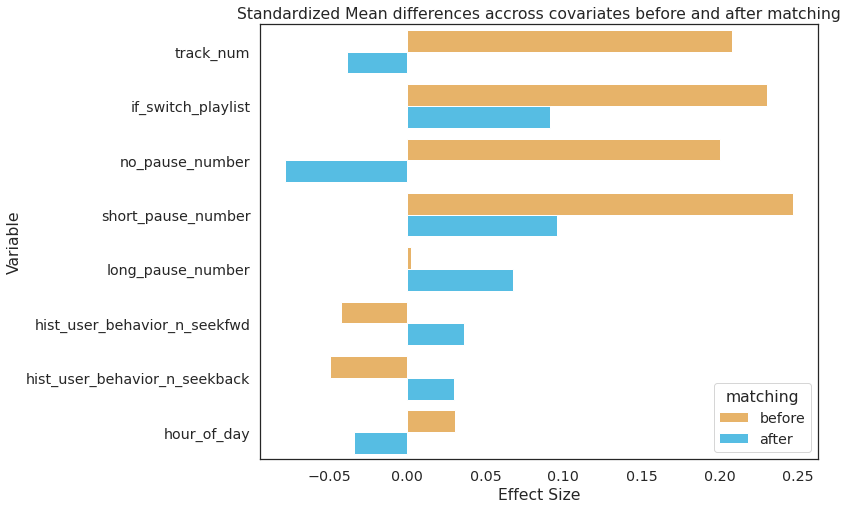

In [64]:
psm.effect_size_plot(save=False)

In [65]:
untreated_matched_data = session[session['session_id'].isin(psm.matched_ids['session_id']) == True]

In [66]:
treated_matched_data = session[session['session_id'].isin(psm.matched_ids['matched_ID']) == True]

In [67]:
all_matched = pd.concat([treated_matched_data, untreated_matched_data])

In [68]:
fit = ols('skipped ~ C(premium)', data=all_matched).fit() 
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                skipped   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     14.97
Date:                Sat, 07 May 2022   Prob (F-statistic):           0.000111
Time:                        23:39:35   Log-Likelihood:                -11874.
No. Observations:                3940   AIC:                         2.375e+04
Df Residuals:                    3938   BIC:                         2.376e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              8.6223      0.111     77.647      0.000       8.405       8.840
C(premium)[T.True]    -0.6076      0.157     -3.869      0.000      -0.916      -0.300
==============================================================================
Omnibus:                      606.994   Durbin-Watson:                   1.951
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              224.719
Skew:                           0.377   Prob(JB):                     1.60e-49
Kurtosis:                       2.106   Cond. No.                         2.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but NearestNeighbors was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


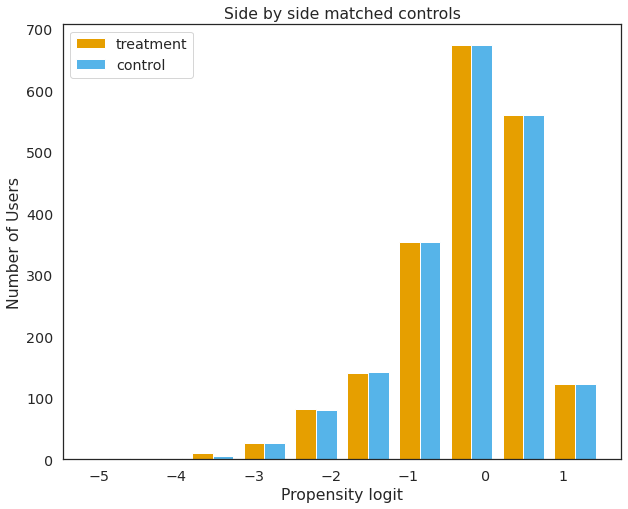

In [72]:
# change to with caliper=0.005
psm.knn_matched(matcher='propensity_logit', replacement=True, caliper=0.005)
sns.set(rc={'figure.figsize':(10,8)}, font_scale = 1.3)
psm.plot_match(Title='Side by side matched controls', Ylabel='Number of Users', Xlabel= 'Propensity logit', names = ['treatment', 'control'], save=True)


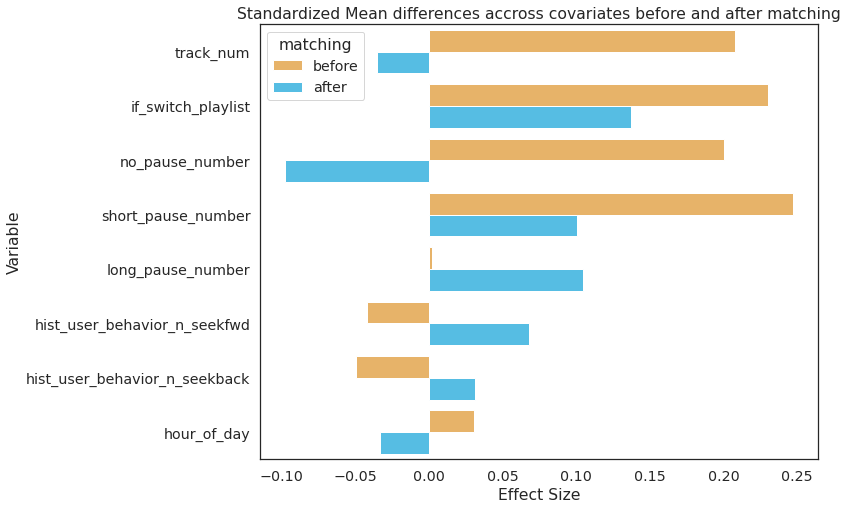

In [73]:
psm.effect_size_plot(save=False)

In [74]:
untreated_matched_data = session[session['session_id'].isin(psm.matched_ids['session_id']) == True]

In [75]:
treated_matched_data = session[session['session_id'].isin(psm.matched_ids['matched_ID']) == True]

In [76]:
all_matched = pd.concat([treated_matched_data, untreated_matched_data])

In [77]:
fit = ols('skipped ~ C(premium)', data=all_matched).fit() 
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                skipped   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     8.396
Date:                Sat, 07 May 2022   Prob (F-statistic):            0.00378
Time:                        23:42:54   Log-Likelihood:                -10162.
No. Observations:                3361   AIC:                         2.033e+04
Df Residuals:                    3359   BIC:                         2.034e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              8.6223      0.112     76.881      0.000       8.402       8.842
C(premium)[T.True]    -0.5052      0.174     -2.898      0.004      -0.847      -0.163
==============================================================================
Omnibus:                      595.010   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              193.918
Skew:                           0.361   Prob(JB):                     7.78e-43
Kurtosis:                       2.070   Cond. No.                         2.46
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""